# Проект: Телеком

___
**Описание проекта**  

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг:  

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.  
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:  

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);  
* Выделенная линия технической поддержки (*TechSupport*);  
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);  
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

___
**Цель**  

Необходимо научиться `прогнозировать отток клиентов`.  

Для успешного достижения цели, необходимо выполнить следующие задачи:  

1. Загрузить и осмотреть данные;  
2. Подготовить данные;  
3. Исследовать модели разны алгоритмов;  
4. Выбрать и протестировать одну лучшую модель;  
5. Подготовить отчёт для заказчика.

___
**Условия задачи:**

1. Основная метрика - `AUC-ROC`;
2. Пороговое значение основной метрики - `>= 0.85`;
3. Дополнительно (для отчёта) считаем и интерпретируем метрику `Accuracy`.
 
___
**Описание данных:**  

Данные состоят из файлов, полученных из разных источников:  

`/datasets/contract_new.csv` — информация о договоре;  
`/datasets/personal_new.csv` — персональные данные клиента;  
`/datasets/internet_new.csv` — информация об интернет-услугах;  
`/datasets/phone_new.csv` — информация об услугах телефонии.  

Во всех файлах столбец `customerID` содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.

*Признаки:*

- `BeginDate` – дата начала пользования услугами;  
- `EndDate` – дата окончания пользования услугами;  
- `Type` – тип оплаты: ежемесячный, годовой и т.д.;  
- `PaperlessBilling` – электронный платёжный документ;  
- `PaymentMethod` – способ оплаты;  
- `MonthlyCharges` – ежемесячные траты на услуги по договору;  
- `TotalCharges` – всего потрачено денег на услуги;  
- `Dependents` – наличие иждивенцев;  
- `Senior Citizen` – наличие пенсионного статуса по возрасту;  
- `Partner` – наличие супруга(и);  
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка.  

*Целевой признак:*  

- Необходимо сформировать самостоятельно с помощью `EndDate`.

<h1>Содержание<span class="tocSkip"></span></h1><br>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li>
        <li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Подготовка данных</a></span></li>
        <li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-3"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Исследование моделей</a></span></li>
        <li><span><a href="#Анализ-лучшей-модели" data-toc-modified-id="Анализ-лучшей-модели-4"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Анализ лучшей модели</a></span></li>
        <li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Общий вывод</a></span></li>
        <li><span><a href="#Отчет-о-проделаной-работе" data-toc-modified-id="Отчет-о-проделаной-работе-6"><span class="toc-item-num">6.&nbsp;&nbsp;</span>Отчет о проделаной работе</a></span></li>
    </ul>
</div>

## Исследовательский анализ данных

### Импортируем необходимые библиотеки

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats as st

In [2]:
pip install ydata-profiling
pip install phik
pip install lightgbm

In [3]:
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb
from catboost.utils import get_roc_curve, select_threshold
from catboost.utils import get_fpr_curve, get_fnr_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from ydata_profiling import ProfileReport
import phik

### Считаем данные из csv-файлов в датафреймы и сохраним в переменные. Путь к файлам:

- `/datasets/contract_new.csv`;  
- `/datasets/personal_new.csv`;  
- `/datasets/internet_new.csv`;  
- `/datasets/phone_new.csv`.

**Откроем файлы `/datasets/contract_new.csv`, `/datasets/personal_new.csv`, `/datasets/internet_new.csv`, `/datasets/phone_new.csv`, и сохраним датафреймы в переменные `contract`, `personal`, `internet`, `phone` соответственно.**

In [6]:
def read_csv_to_df(files_dict):
    """
    Функция для чтения нескольких файлов .csv в датафреймы pandas.

    :param files_dict: словарь с именами датафреймов и расположением файлов
    :return: словарь с датафреймами pandas
    """
    dataframes = {}
    for name, path in files_dict.items():
        if os.path.exists(path):
            dataframes[name] = pd.read_csv(path)
        else:
            print(f"Файл {path} не найден.")
    return dataframes

In [7]:
#files_dict = {
#    'contract': './contract_new.csv',
#    'personal': './personal_new.csv',
#    'internet': './internet_new.csv',
#    'phone': './phone_new.csv'
#}
#
#dataframes = read_csv_to_df(files_dict)

**Ниже код для считывания файлов в Яндекс Практикуме.**

In [8]:
files_dict = {
    'contract': '/datasets/contract_new.csv',
    'personal': '/datasets/personal_new.csv',
    'internet': '/datasets/internet_new.csv',
    'phone': '/datasets/phone_new.csv'
}

dataframes = read_csv_to_df(files_dict)

### Изучим общую информацию о полученных датафреймах

**Добавим настройки для удобства отображения данных.**

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format

#Если необходимо вернуть дефолтные настройки, раскомментируй строку ниже
#pd.reset_option('all')

**Выведем первые 5 строчек из полученных датафреймов на экран.**

In [10]:
for dataframe_name, dataframe in dataframes.items():
    print(f'\033[1m\33[34m\nДатафрейм: {dataframe_name}\33[0m')
    display(dataframe.head(5))


Датафрейм: contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Датафрейм: personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Датафрейм: internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Датафрейм: phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Для удобства, сразу приведем обозначения признаков в датафреймах к "змеиному" регистру.**

In [11]:
dataframes['contract'].columns = dataframes['contract'].columns.str.lower()

In [12]:
dataframes['contract'] = dataframes['contract'].rename(columns={
    'customerid': 'customer_id',
    'begindate': 'begin_date',
    'enddate': 'end_date',
    'paperlessbilling': 'paperless_billing',
    'paymentmethod': 'payment_method',
    'monthlycharges': 'monthly_charges',
    'totalcharges': 'total_charges'
})

In [13]:
dataframes['personal'].columns = dataframes['personal'].columns.str.lower()

In [14]:
dataframes['personal'] = dataframes['personal'].rename(columns={
    'customerid': 'customer_id',
    'seniorcitizen': 'senior_citizen'
})

In [15]:
dataframes['internet'].columns = dataframes['internet'].columns.str.lower()

In [16]:
dataframes['internet'] = dataframes['internet'].rename(columns={
    'customerid': 'customer_id',
    'internetservice': 'internet_service',
    'onlinesecurity': 'online_security',
    'onlinebackup': 'online_backup',
    'deviceprotection': 'device_protection',
    'techsupport': 'tech_support',
    'streamingtv': 'streaming_tv',
    'streamingmovies': 'streaming_movies'
})

In [17]:
dataframes['phone'].columns = dataframes['phone'].columns.str.lower()

In [18]:
dataframes['phone'] = dataframes['phone'].rename(columns={
    'customerid': 'customer_id',
    'multiplelines': 'multiple_lines'
})

**Посмотрим как выглядят измененные обозначения признаков.**

In [19]:
for dataframe_name, dataframe in dataframes.items():
    print(f'\033[1m\33[34m\nДатафрейм: {dataframe_name}\33[0m')
    print(dataframe.columns)


Датафрейм: contract
Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Датафрейм: personal
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Датафрейм: internet
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Датафрейм: phone
Index(['customer_id', 'multiple_lines'], dtype='object')


**Посмотрим на размер данных (количество строк, колонок).**

In [20]:
for dataframe_name, dataframe in dataframes.items():
    print(f'\033[1m\33[34m\nДатафрейм: {dataframe_name}\33[0m')
    print(f'Количество строк: {dataframe.shape[0]}\nКоличество колонок: {dataframe.shape[1]}\n')


Датафрейм: contract
Количество строк: 7043
Количество колонок: 8


Датафрейм: personal
Количество строк: 7043
Количество колонок: 5


Датафрейм: internet
Количество строк: 5517
Количество колонок: 8


Датафрейм: phone
Количество строк: 6361
Количество колонок: 2



**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [21]:
for dataframe_name, dataframe in dataframes.items():
    print(f'\033[1m\33[34m\nДатафрейм: {dataframe_name}\33[0m')
    display(dataframe.describe(include = "all"))


Датафрейм: contract


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,7043,7043,7043,7043,7043,"7,043.00",7043
unique,7043,77,67,3,2,4,NaN,6658
top,2309-OSFEU,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.76,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.09,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.25,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.50,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.35,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.85,NaN



Датафрейм: personal


,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,"7,043.00",7043,7043
unique,7043,2,NaN,2,2
top,2309-OSFEU,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.16,NaN,NaN
std,NaN,NaN,0.37,NaN,NaN
min,NaN,NaN,0.00,NaN,NaN
25%,NaN,NaN,0.00,NaN,NaN
50%,NaN,NaN,0.00,NaN,NaN
75%,NaN,NaN,0.00,NaN,NaN



Датафрейм: internet


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2309-OSFEU,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Датафрейм: phone


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,0862-PRCBS,No
freq,1,3390


**Выведем основную информацию о датафреймах с помощью метода `info()`.**

In [22]:
for dataframe_name, dataframe in dataframes.items():
    print(f'\033[1m\33[34m\nДатафрейм: {dataframe_name}\33[0m')
    print(dataframe.info())


Датафрейм: contract
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Датафрейм: personal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-n

**Выведем количество пропущенных значений для каждой колонки.**

In [23]:
for dataframe_name, dataframe in dataframes.items():
    print(f'\033[1m\33[34m\nДатафрейм: {dataframe_name}\33[0m')
    display(pd.DataFrame(dataframe.isna().sum()).style.background_gradient('coolwarm'))


Датафрейм: contract


,0
customer_id,0
begin_date,0
end_date,0
type,0
paperless_billing,0
payment_method,0
monthly_charges,0
total_charges,0



Датафрейм: personal


,0
customer_id,0
gender,0
senior_citizen,0
partner,0
dependents,0



Датафрейм: internet


,0
customer_id,0
internet_service,0
online_security,0
online_backup,0
device_protection,0
tech_support,0
streaming_tv,0
streaming_movies,0



Датафрейм: phone


,0
customer_id,0
multiple_lines,0


**Проверим дубликаты.**

In [24]:
for dataframe_name, dataframe in dataframes.items():
    print(f'\033[1m\33[34m\nДатафрейм: {dataframe_name}\33[0m')
    print(dataframe.duplicated().sum())


Датафрейм: contract
0

Датафрейм: personal
0

Датафрейм: internet
0

Датафрейм: phone
0


### Изучим общую информацию о полученных датафреймах используя бибилиотеку `ydata-profiling`

**Для отображения данных, используем словарь и цикл, созданный ранее.**

### Выводы исследования данных

**Датафрейм: contract**  

1. Имеем 7043 уникальных строк;
2. В признаке begin_date, видим чередующиеся пики подключений. Возможно они связаны с проведением рекламных акций;
3. В признаке end_date, основная масса абонентов - 5942 человек, остаются активными;
4. Половина абонентов оплачивают подписку на услуги помесячно. Оставшаяся половина пользуется годовой и двухлетней подпиской 50/50 соответственно. Возможно оплата сразу на год-два выгоднее с финансовой точки зрения;
5. В признаке payment_method видим, что почти половина пользователей, подписались на автоматическую оплату. Что говорит о доверии к провайдеру;
6. В признаке monthly_charges можем увидеть, что первые абоненты тратили на услуги больше всего, возможно тариф был только с оплатой на год вперед. Также видим, что в послединие месяцы, ежемесячные расходы пользователей уменьшились.

**Найденные проблемы в датафрейме contract:**  

* В begin_date необходимо сменить тип данных на datetime;
* В monthly_charges необходимо сменить тип данных на int;
* В total_charges имеются незаполнненные ячейки (пропуски данных), также необходимо сменить тип данных на float, после заполнения пропусков.

**Датафрейм: personal**  

1. Имеем 7043 уникальных строк;
2. Распределение гендеров 50/50;
3. 12.5% абонентов имеют пенсионный статус;
4. 50% абонентов имеют статус супруга;
5. 30% абонентов имеют иждевенца;
6. Проблем с данными не выявлено. Признаки распределены нормально. Возможно нужно будет пораборать с дисбалансом в признаке senior_citizen и dependents.

**Датафрейм: internet**  

1. Имеем 5517 уникальных строк;
2. Чуть более половины абонентов пользуется услугой оптоволоконной связи, оставшаяся часть пользуется улугой DSL;
3. Примерно 40% абонентов пользуется дополнительными услугами, которые предоставляет оператор;
4. Проблем с данными не выявлено.

**Датафрейм: phone**  

1. Имеем 6361 уникальных строк;
2. Чуть менее половины абонентов имеют наличие возможности ведения параллельных линий во время звонка;
3. Проблем с данными не выявлено.

## Подробный план работ

1. Исправляем найденные проблемы в датафрейме contract;
2. Соединяем датафреймы. Следим за тем, чтобы данные не потерялись;
3. Исследуем корреляцию, используем библиотеку phik;
4. Готовим итоговую таблицу. Выполняем отбор признаков. Выделяем целевой признак EndDate;
5. Анализируем распределение признаков;
6. Кодируем признаки. Выделяем тестовую выборку;
7. Исследуем модели - не менее двух разных алгоритмов. Используем только интерпретируемые модели;
8. Подбираем гиперпараметры, оцениваем модели на кросс-валидации.
9. Выбираем одну лучшую модель, оцениваем её на test выборке.

## Подготовка данных

### Устранение проблем в датафрейме `contract`

**В признаке `begin_date` изменим тип данных на `datetime64`.**

In [25]:
dataframes['contract']['begin_date'] = pd.to_datetime(dataframes['contract']['begin_date'], format='%Y-%m-%d')

**В признаке `monthly_charges` изменим тип данных на `int64`.**

In [26]:
dataframes['contract']['monthly_charges'] = dataframes['contract']['monthly_charges'].astype('int64')

**В признаке `total_charges` имеются незаполнненные ячейки (пропуски данных), отобразим их.**

In [27]:
dataframes['contract'].query('total_charges ==  " "')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73,


In [28]:
dataframes['contract']['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

**Видим, что дата начала использования услуги `begin_date` совпадает с датой выгрузки датафрейма. Можем сделать предположить, что биллинговая система оператора, оставляет пустым поле `total_charges`, в случае, если абонент пользуется услугами сутки или меньше суток.**  
**Незаполнненные ячейки (пропуски данных) заменим на ноль.**

In [29]:
dataframes['contract'].loc[dataframes['contract']['total_charges'] == " ", 'total_charges'] = 0

**В признаке `total_charges` изменим тип данных на `float64`.**

In [30]:
dataframes['contract']['total_charges'] = dataframes['contract']['total_charges'].astype('float64')

### Создание целевого и дополнительных признаков

**Добавим целевой признак `target_feature`. Если в признаке `end_date` присутствует дата, запишем `0` = Yes, иначе нет запишем `0` = No.**

In [31]:
dataframes['contract']['target_feature'] = dataframes['contract']['end_date'].apply(lambda x: x if x == 'No' else 'Yes')

**Добавим признак, в котором определим длительность контракта абонента. Для этого вычтем начальную дату из конечной и запишем разницу в признак `duration`.**

**В признаке `end_date` значение `No` соответствует дате выгрузке датафрейма `2020-02-01 00:00:00`. Заменим значение `No` на дату выгрузки.**

In [32]:
dataframes['contract']['end_date'] = dataframes['contract']['end_date'].apply(lambda x: '2020-02-01' if x == 'No' else x)

**Изменим тип данных на `datetime64`.**

In [33]:
dataframes['contract']['end_date'] = pd.to_datetime(dataframes['contract']['end_date'], format='%Y-%m-%d')

**Найдём разницу и запишем её в признак `duration`.**

In [34]:
dataframes['contract']['duration'] = (dataframes['contract']['end_date'] - dataframes['contract']['begin_date']).dt.days

### Объединение датафреймов

**Используем метод `.merge`. Объединять будем по признаку `customer_id`.**

In [35]:
df = dataframes['contract'] \
    .merge(dataframes['personal'], how='left', on='customer_id') \
    .merge(dataframes['internet'], how='left', on='customer_id') \
    .merge(dataframes['phone'], how='left', on='customer_id') 

**Выведем основную информацию о датафрейме `df` с помощью метода `info()`.**

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   int64         
 7   total_charges      7043 non-null   float64       
 8   target_feature     7043 non-null   object        
 9   duration           7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

**Переменную `dataframes` можем удалить.**

In [37]:
del dataframes

### Работа с пропусками в датафрейме `df`, после объединения

**Выведем количество пропущенных значений для каждой колонки.**

In [38]:
pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')

,0
customer_id,0
begin_date,0
end_date,0
type,0
paperless_billing,0
payment_method,0
monthly_charges,0
total_charges,0
target_feature,0
duration,0


**Пропуски в признаках `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines` означают, что услуги не подключены.**

**Заменим пропуски на значение `No`.**

In [40]:
df = df.fillna('No')

### Исследование корреляции признаков

**В датафрейме присутствуют категориальные признаки. Для исследования корреляции категориальных признаков будем использовать библиотеку `phik`.**

**Создадим списки с числовыми и категориальными признаками.**

In [41]:
numerical_cols = ['monthly_charges', 'total_charges', 'duration']

categorical_cols = ['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines']

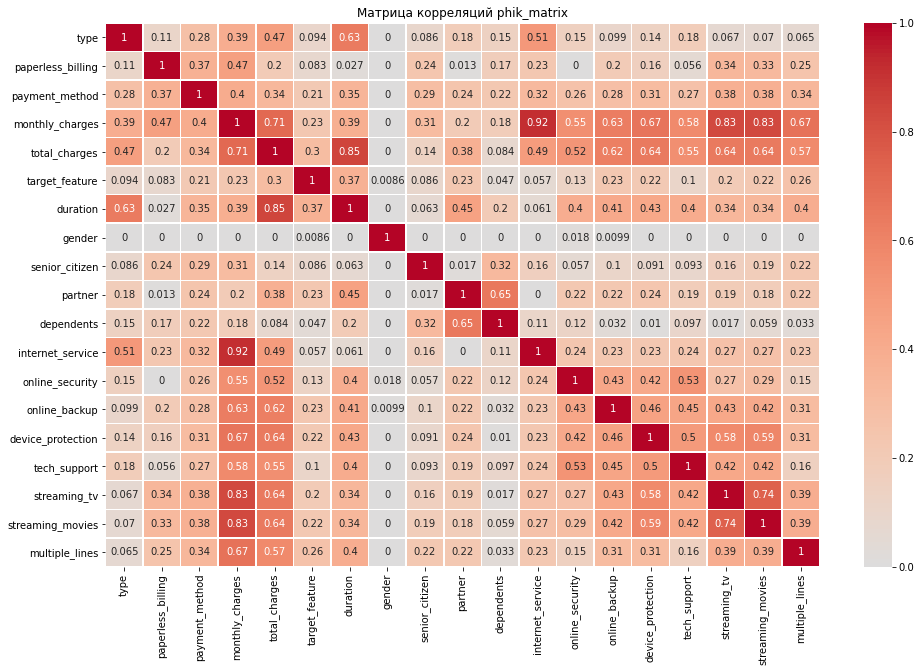

In [42]:
plt.figure(figsize=(16, 10))

corr_matrix = df.drop(columns=['customer_id', 'begin_date', 'end_date']).phik_matrix(interval_cols=numerical_cols)

sns.heatmap(corr_matrix, linewidths=.5, cmap='coolwarm', center=0, annot=True)

plt.title('Матрица корреляций phik_matrix')
plt.show()

**Имеется корреляция между месячными, суммарными тратами и дополнительными услугами.**  
**Признак `gender` имеет нулевую корреляцию со всеми признаками.**  
**Целевой признак не имеет сильно выраженной корреляции с остальными признаками.**

### Исследование дисбаланса классов

**Распределение целевого признака `target_feature`.**

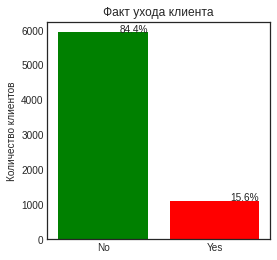

In [43]:
plt.figure(figsize=(4, 4))
plt.style.use('seaborn-white')
palette = {'No': 'green', 'Yes': 'red'}
total = float(len(df))
ax = sns.countplot(data=df, x='target_feature', palette=palette, saturation=1)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.xlabel(None)
plt.ylabel('Количество клиентов')
plt.title('Факт ухода клиента')
plt.show()

**Явный дисбаланс классов в признаке `target_feature`, несбалансирован примерно `5:1`.**

**В приложенном датасете `84.4%` абонентов продолжают пользоваться услугами оператора и `15.6%` отказавшихся от услуг. В данном признаке `target_feature`, имеем дело с проблемой несбалансированного класса.
Модели машинного обучения обычно работают лучше, когда число представителей каждого класса примерно одинаково. Возможно, при использовании линейных моделей обучения, придется устранить этот дисбаланс целевого признака.**

**Распределения числовых признаков.**

In [44]:
def countplot_categories(data, x, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, hue=None, figsize=(3 , 3)):
    
    plt.figure(figsize=figsize)
    
    for i in enumerate(x):
        plt.subplot(nrows, ncols, i[0] + 1)
        sns.histplot(data=data, x=i[1], hue=hue)
        plt.xlabel(i[1])
        plt.ylabel(ylabel)

    plt.suptitle(suptitle, fontsize=22)
    plt.show()

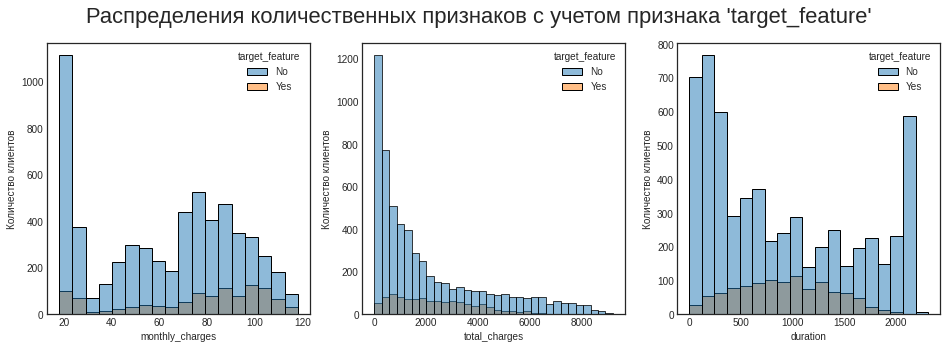

In [45]:
hue='target_feature'

countplot_categories(data=df,
                     x=numerical_cols,
                     xlabel=None,
                     ylabel='Количество клиентов',
                     hue=hue,
                     suptitle=(f'Распределения количественных признаков c учетом признака \'{hue}\''),
                     nrows=1,
                     ncols=3,
                     figsize=(16, 5))

**На графике `monthly_charges` видим, что абоненты с большими ежемесячными затратами, склонны разрывать контракт.**  
**На графике `duration` видим, что абоненты со средним периодом, склонны разрывать контракт.**  

**Распределения категориальных признаков.**

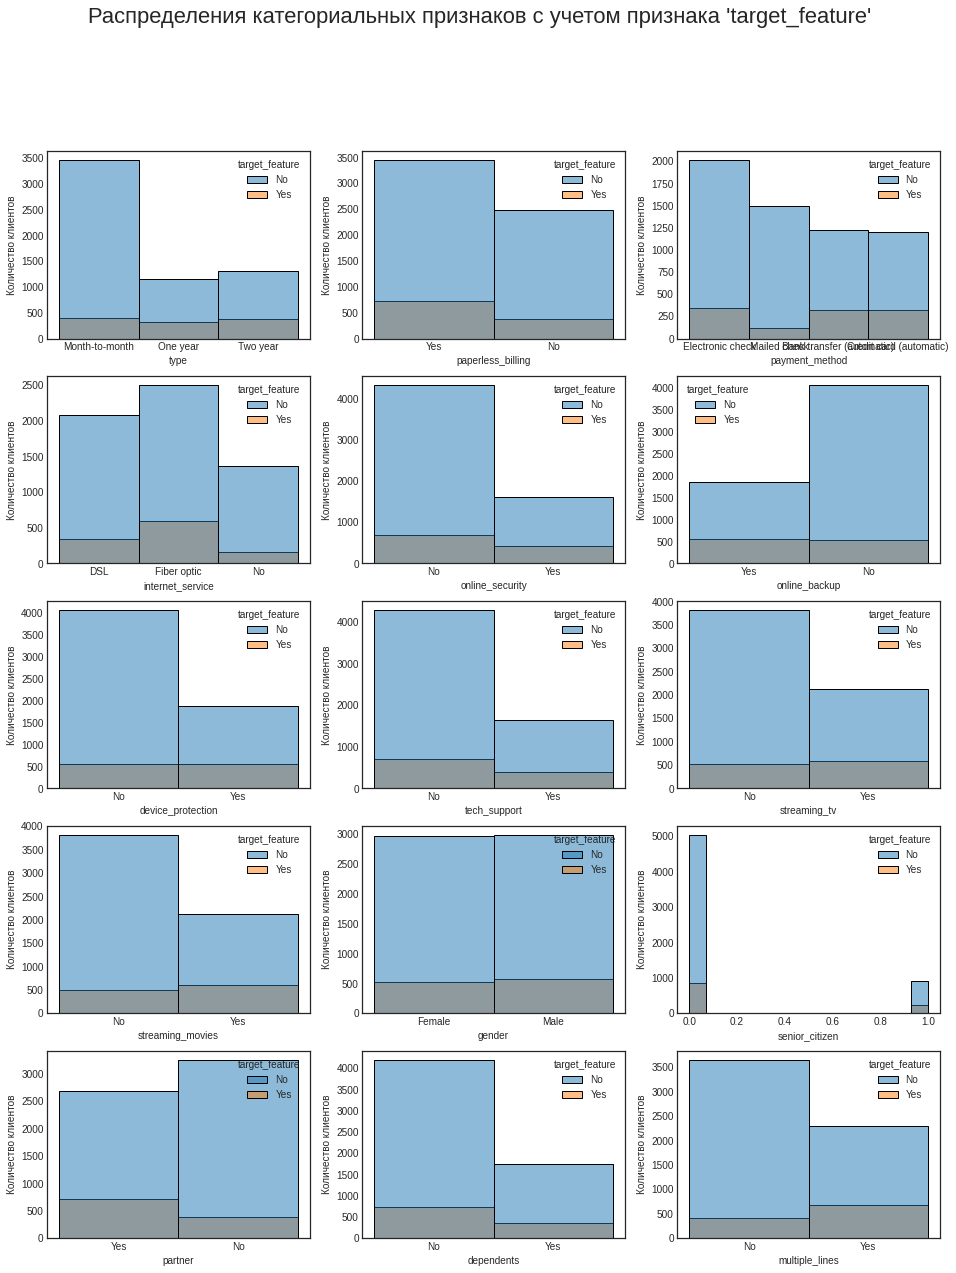

In [46]:
hue='target_feature'

countplot_categories(data=df,
                     x=categorical_cols,
                     xlabel=None,
                     ylabel='Количество клиентов',
                     hue=hue,
                     suptitle=(f'Распределения категориальных признаков c учетом признака \'{hue}\''),
                     nrows=5,
                     ncols=3,
                     figsize=(16, 20))

**В большинстве категориальных признаках наблюдается дисбаланс классов. Внутри классов наблюдается дисбаланс по отношению к целевому признаку.**  
**Вывод: решаем задачу классификации с дисбалансом классов.**

## Исследование моделей

In [47]:
RANDOM_STATE = 50623

**Для дальнейшего удобства изменим целевой признак на числовой.**

In [48]:
df['target_feature'] = df['target_feature'].map({'Yes': 1, 'No': 0}).astype('int64')

### Разделим данные на `признаки` и `целевой признак`:

* `X` — «признаки»;
* `y` — «целевой признак».

In [49]:
X = df[numerical_cols + categorical_cols]
print(X.shape)

(7043, 18)


In [50]:
y = df['target_feature']
print(y.shape)

(7043,)


**Разделим полученные данные в переменных `X`, `y` на `обучающую` и `тестовую` выборки в пропорции `75`:`25`.**

**Данные запишем в новые переменные:**  

`X_train` - `75%`  
`X_test` - `25%`  
`y_train` - `75%`  
`y_test` - `25%`  

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=y)

### Пайплайн для обучения:

In [52]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

### RandomForestClassifier

**Обучим модель RandomForestClassifier.**

In [53]:
model_RandomForestClassifier = GridSearchCV(
    Pipeline(steps=[("preprocessor", preprocessor), ("clf", RandomForestClassifier(random_state=RANDOM_STATE))]), 
    param_grid={
        'clf__n_estimators': [500, 1000, 1500],
        'clf__criterion': ['gini', 'entropy']
    },
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

In [54]:
%%time
model_RandomForestClassifier.fit(X_train, y_train)

CPU times: user 1min 14s, sys: 512 ms, total: 1min 14s
Wall time: 1min 15s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'duration']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                      

In [55]:
%%time
model_RandomForestClassifier.fit(X_train, y_train)

CPU times: user 1min 13s, sys: 428 ms, total: 1min 14s
Wall time: 1min 14s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'duration']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                      

In [56]:
model_RandomForestClassifier.best_params_

{'clf__criterion': 'entropy', 'clf__n_estimators': 1000}

In [57]:
model_RandomForestClassifier.best_score_

0.8108664342131952

### LGBMClassifier

**Обучим модель LGBMClassifier.**

In [58]:
model_LGBMClassifier = GridSearchCV(
    Pipeline(steps=[("preprocessor", preprocessor), ("clf", lgb.LGBMClassifier(random_state=RANDOM_STATE))]), 
    param_grid={
        'clf__max_depth': [2, 4, 6],
        'clf__learning_rate': [0.03, 0.1],
        'clf__n_estimators': [20, 30, 100]
    },
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

In [59]:
%%time
model_LGBMClassifier.fit(X_train, y_train)

CPU times: user 23min 16s, sys: 14.9 s, total: 23min 31s
Wall time: 23min 37s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'duration']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                      

In [60]:
model_LGBMClassifier.best_params_

{'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 100}

In [61]:
model_LGBMClassifier.best_score_

0.8447269479781481

### CatBoostClassifier

**Обучим модель CatBoostClassifier**

In [62]:
train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_cols
)

test_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=categorical_cols
)

**Подберем гиперпараметры через встроенный GridSearch.**

In [63]:
model_CatBoostClassifier = CatBoostClassifier(
    n_estimators=3000,
    loss_function='Logloss',
    verbose=False,
    eval_metric='AUC:hints=skip_train~false',
    one_hot_max_size=3,
    random_seed=RANDOM_STATE
    )

grid_search_result = model_CatBoostClassifier.grid_search({
    'l2_leaf_reg': np.linspace(0.05, 0.25, 10),
    'learning_rate': [0.04, 0.05]
    },
    train_data,
    cv=3,
    partition_random_seed=RANDOM_STATE,
    refit=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8872266812
bestIteration = 942

0:	loss: 0.8872267	best: 0.8872267 (0)	total: 13.6s	remaining: 4m 17s

bestTest = 0.8796416915
bestIteration = 921

1:	loss: 0.8796417	best: 0.8872267 (0)	total: 26.6s	remaining: 3m 59s

bestTest = 0.8802790268
bestIteration = 1061

2:	loss: 0.8802790	best: 0.8872267 (0)	total: 40s	remaining: 3m 46s

bestTest = 0.8763779748
bestIteration = 1257

3:	loss: 0.8763780	best: 0.8872267 (0)	total: 53s	remaining: 3m 31s

bestTest = 0.8794385847
bestIteration = 1121

4:	loss: 0.8794386	best: 0.8872267 (0)	total: 1m 5s	remaining: 3m 17s

bestTest = 0.8856018266
bestIteration = 1371

5:	loss: 0.8856018	best: 0.8872267 (0)	total: 1m 18s	remaining: 3m 3s

bestTest = 0.8768822401
bestIteration = 1107

6:	loss: 0.8768822	best: 0.8872267 (0)	total: 1m 31s	remaining: 2m 50s

bestTest = 0.8853146755
bestIteration = 1536

7:	loss: 0.8853147	best: 0.8872267 (0)	total: 1m 44s	remaining: 2m 37s

bestTest = 0.878500091
bestIteration = 1920

8:	loss: 0.8785001	bes

**Вывод:**  

**Максимальную оценку, среди всех моделей, равную `ROC_AUC = 0.87`, получил `CatBoostClassifier`.**  
**Выбираем модель `CatBoostClassifier` для дальнейшего тестирования.**

## Анализ лучшей модели

**Выведем `ROC_AUC` на тесте.**

In [64]:
roc_auc = roc_auc_score(y_test, model_CatBoostClassifier.predict_proba(X_test)[:, 1])
print(roc_auc)

0.9215343203230147


**Отличная оценка `roc_auc`.**

**Выведем метрику `Accuracy` на тесте.**

In [65]:
accuracy_score(y_test, (model_CatBoostClassifier.predict(X_test)).round())

0.9153889835320841

**Отличная оценка `accuracy_score`.**

**Выведем график.**

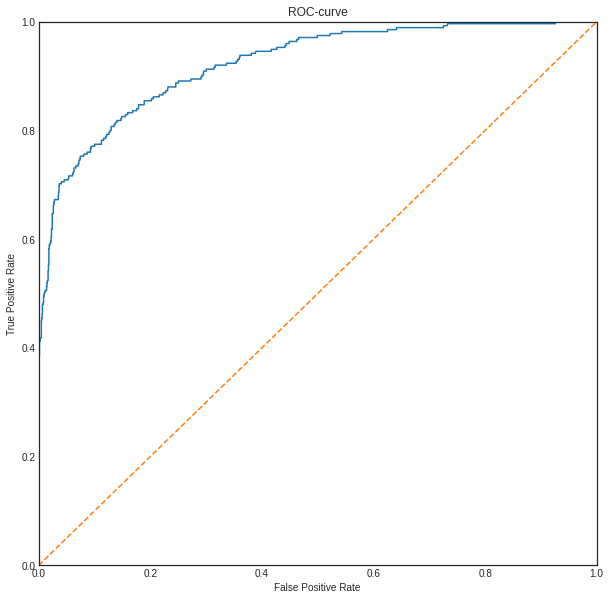

In [66]:
probabilities_test = model_CatBoostClassifier.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

**Отличная оценка `roc_auc` и хороший график.**

**Построим матрицу ошибок.**

In [67]:
cm = confusion_matrix(y_test, model_CatBoostClassifier.predict(X_test))

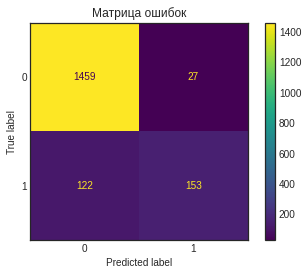

In [70]:
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title('Матрица ошибок')
plt.savefig('./confusion_matrix.png')
plt.show()

**Модель достаточно редко ошибается в том, что клиент останется. Но почти в половине случаев ошибается с тем, кто вероятнее всего уйдет.**

**Оценим важность признаков лучшей модели. Отобразим их на графике.**

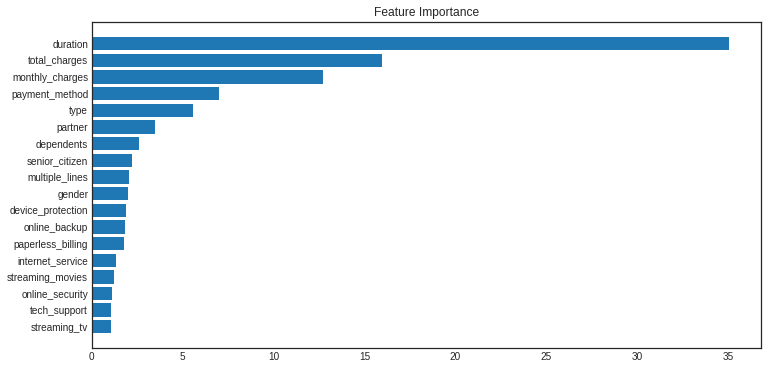

In [71]:
feature_importance = model_CatBoostClassifier.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.savefig('./feature_importance.png')
plt.show()

**Самым важным признаком, оказался новый созданный признак `duration`. Также, важными признаками оказались общее количество потраченных денег и размер месячных расходов. Некоторое влияние оказывает то, как человек оплачивает услуги.**

## Общий вывод

**Успешно научились прогнозировать отток клиентов для оператора связи «Ниединогоразрыва.ком».**  

**Выполнены следующие задачи:**  

- Данные загружены и осмотрены, объеденены из разных таблиц по разным видам услуг;
- Данные успешно подготовлены для исследования моделей;
- Исследованы модели разны алгоритмов;
- Выбрана и протестирована одна лучшая модель.


## Отчет о проделаной работе

**1. Выполненные ключевые шаги в ходе проекта:**

   - Первичный анализ данных (EDA);
   - Предобработка данных (исправление найденных проблем, преобразование и выбор признаков);
   - Составление новых признаков;
   - Оценка корреляции и выбор наилучших признаков;
   - Подготовка итогового датафрейма;
   - Разделение на тренировочную и тестовую выборки в соотношении 75% на 25%;
   - Создание пайплайна для моделей (кодирование и масштабирование признаков);
   - Исследование моделей;
   - Подбор лучших гиперпараметров, оценка моделей на кроссвалидации;
   - Выбор лучшей модели и оценка на тестовой выборке.  


**2. Ход фактической работы, соответствовал запланированным шагам, определенные в плане работ.**  


**3. В процессе работы возникли следующие трудности:**  

 - В признаке `total_charges` оказались ячейки с пропущенными данными, которые было сложно интерпритировать;
 - Оценка мультиколлинеарности признаков;
 - Выбор подходящих гиперпараметров.  

 С оценкой корреляции помогла библиотека phik и корреляционная матрица. С выбором гиперпараметров помог GridSearchCV и несколько тестовых запусков моделей.  


**4. Итоговый список отобранных признаков, для обучения моделей:**  

*Признаки:*

- `duration` – новый признак, который хранит иформацию о разнице начала пользования услугами и окончания пользования услугами в днях;  
- `type` – тип оплаты: ежемесячный, годовой и т.д.;  
- `paperless_billing` – электронный платёжный документ;  
- `payment_method` – способ оплаты;  
- `monthly_charges` – ежемесячные траты на услуги по договору;  
- `total_charges` – всего потрачено денег на услуги;  
- `dependents` – наличие иждивенцев;  
- `senior_citizen` – наличие пенсионного статуса по возрасту;  
- `partner` – наличие супруга(и);  
- `multiple_lines` – наличие возможности ведения параллельных линий во время звонка;  
- `gender` - пол абонента;  
- `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` - дополнительные услуги, предоставляемые оператором.  

*Целевой признак:*  

- `target_feature` - формирован самостоятельно с помощью `EndDate`.  

    Для обучения моделей, признаки были стандартизированы с помощью `StandardScaler()` и кодированы с помощью `OrdinalEncoder()` в пайплайне.  


**5. Краткое описание предобработки данных:**  

 - В признаке `begin_date` изменен тип данных на `datetime64`;
 - В признаке `monthly_charges` изменен тип данных на `int64`;
 - В признаке `total_charges` имелись незаполнненные ячейки (пропуски данных), они были заполнены нулевым значением. Далее изменен тип данных на `float64`;
 - В признаке `end_date` значение `No` соответствовало дате выгрузке датафрейма `2020-02-01`, соответственно значение `No` было заменено на дату выгрузки. Далее изменен тип данных на `datetime64`.  


**6. Сводная таблица исследованных моделей и их метрика на кросс-валидации:**  

| Исследованная модель   | AUC-ROC |
|------------------------|---------|
| RandomForestClassifier | 0.81    |
| LGBMClassifier         | 0.87    |
 CatBoostClassifier     | 0.89    |  


**7. Лучшая модель: `CatBoostClassifier`.**  

**Гиперпараметры модели:**  

{'loss_function': 'Logloss',  
 'random_seed': 50623,  
 'verbose': False,  
 'one_hot_max_size': 3,  
 'eval_metric': 'AUC:hints=skip_train~false',  
 'n_estimators': 3000,  
 'learning_rate': 0.04,  
 'l2_leaf_reg': 0.05}  

**Метрика модели на кросс-валидации равна `0.89`.**  


**8. Итоговая метрика на `test`:**  

AUC-ROC равен `0.92`;
Accuracy равен `0.91`.  


**9. Матрица ошибок.**

![Матрица ошибок]('./confusion_matrix.png')  

|  TP  |  FP |
|------|-----|
| 1459 |  27 |

|  FP  |  TN |
|------|-----|
| 122  | 153 |

Модель достаточно редко ошибается в том, что клиент останется. Но почти в половине случаев ошибается с тем, кто вероятнее всего уйдет.  


**10. Важность признаков.**

![Оценка важности признаков]('./feature_importance.png')

|  Признак         |Вес признака|
|------------------|------------|
|duration          | 35.06986095|    
|total_charges     | 15.98440847|         
|monthly_charges   | 12.72311712|           
|payment_method    | 6.99665945 |          
|type              | 5.58286723 |
|partner           | 3.4697725  |   
|dependents        | 2.58805055 |      
|senior_citizen    | 2.24138074 |          
|multiple_lines    | 2.06252282 |          
|gender            | 1.99605962 |  
|device_protection | 1.8609439  |             
|online_backup     | 1.8609439  |         
|paperless_billing | 1.75391001 |             
|internet_service  | 1.32639507 |            
|streaming_movies  | 1.24260316 |            
|online_security   | 1.12386409 |           
|tech_support      | 1.07409801 |        
|streaming_tv      | 1.07163143 |  

Самым важным признаком, оказался новый созданный признак duration. Также, важными признаками оказались общее количество потраченных денег и размер месячных расходов. Некоторое влияние оказывает то, как человек оплачивает услуги.

Итого:  
Персональные данные, предоставленные оператором о некоторых клиентах, были успешно проанализированы. Дополнительно была учтена информация об тарифах и договорах абонентов. На основе подготовленных данных, была обучена и подготовлена модель прогнозирования для оттока клиентов. Задача поставленная оператором связи «Ниединогоразрыва.ком» выполнена.